In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
df_stock = pd.read_csv("itc/ITC.NS.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df_posts = pd.read_excel("itc/itc_final_posts.xlsx")
# removing the unnecessary columns
df_posts.drop(["Unnamed: 0"], axis=1,inplace=True)
# removing spam posts
df_posts = df_posts[df_posts.Spam==0.0]
df_posts.drop(["Spam"],axis=1,inplace=True)
# sliding a window of 7 days and adding all the TIs
from stock_helper import prepare_data
x,y = prepare_data(df_stock)
# slicing the data
final_x = x[np.datetime64("2021-11-13"):]
final_y = y[np.datetime64("2021-11-13"):]
# reversing the posts data
df_posts = df_posts[::-1]
final_posts = df_posts[7:]
# loading the sentiment analysis model
sent_model = tf.keras.models.load_model("final_bert")
# removing duplicates from the data
final_posts.drop_duplicates(subset=['Messages'])
# calculating the sentiments score
sentiments = []
prev = np.datetime64("2015-11-12 21:31:26")
for i in final_y.index:
    total=0
    cnt=0
    for j in final_posts.itertuples():
        _,msg,time = j
        if np.datetime64(time)<np.datetime64(i) and np.datetime64(time)>prev:
            total += tf.squeeze(sent_model.predict([msg])).numpy()
            cnt+=1
    prev = np.datetime64(i)
    if(cnt==0):
        sentiments.append(0)
    else:
        sentiments.append(total/cnt)
# getting indices where sentiments score is 0
zero_index = []
for i,j in enumerate(sentiments):
    if(j==0):
        zero_index.append(i)
# removing all the zero values indices
sentiments = np.delete(sentiments,zero_index)
final_x_zeros = final_x.copy()
final_y_zeros = final_y.copy()
final_y_zeros = final_y_zeros.to_frame()
final_x_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros = final_y_zeros[final_y_zeros.removal_assist.isin(zero_index)==False]
final_x_zeros = final_x_zeros[final_x_zeros.removal_assist.isin(zero_index)==False]
# removing the added helper column
final_x_zeros.drop(["removal_assist"], axis=1,inplace=True)
final_y_zeros.drop(["removal_assist"], axis=1, inplace=True)

In [2]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_x_zeros_scaled = mms.fit_transform(final_x_zeros)
final_x_zeros_scaled

array([[0.61467075, 1.        , 0.9999995 , ..., 0.        , 0.14490831,
        0.        ],
       [0.8847647 , 0.91495323, 0.77971697, ..., 0.09165436, 0.28882992,
        0.        ],
       [0.9301157 , 0.89471245, 0.7361207 , ..., 0.2254045 , 0.39610314,
        0.        ],
       ...,
       [0.24333572, 0.32355213, 0.42327833, ..., 0.6687889 , 0.52184355,
        0.26923072],
       [0.23974895, 0.3533659 , 0.45800447, ..., 0.8273011 , 0.85380137,
        0.6153846 ],
       [0.23554707, 0.38004112, 0.48953772, ..., 0.984114  , 0.9999999 ,
        0.65384614]], dtype=float32)

In [3]:
k = final_y_zeros.max()
final_y_zeros= final_y_zeros/k
final_y_zeros

,Close
Date,
2021-11-15,0.994155
2021-11-16,0.983090
2021-11-17,1.000000
2021-11-18,0.991649
2021-12-03,0.925470
2021-12-06,0.909812
2021-12-07,0.921294
2021-12-08,0.939248
2021-12-09,0.982881


In [4]:
model_nbeats = tf.keras.models.load_model("nbeats_ITC")
model_nbeats.evaluate(final_x_zeros[42:],final_y_zeros[42:]*k)

1/1 [==============================] - 1s 638ms/step - loss: 2.3721 - mae: 2.3721 - mse: 7.8516


[2.3720510005950928, 2.3720510005950928, 7.851637363433838]

In [5]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=(71))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 71)             0         
                                                                 
 gru (GRU)                   (None, 1, 128)            77184     
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            99072     
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 275,457
Trainable params: 275,457
Non-trainable

In [6]:
model.compile(loss="mae",optimizer = tf.keras.optimizers.Adam(), metrics=["mae","mse"])
history = model.fit(final_x_zeros_scaled[:42],final_y_zeros[:42],
                    epochs = 1000,
                    validation_data = (final_x_zeros_scaled[42:], final_y_zeros[42:]),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                           patience=100, 
                                                           verbose=1)])

Epoch 1/1000
2/2 [==============================] - 4s 643ms/step - loss: 0.9129 - mae: 0.9129 - mse: 0.8357 - val_loss: 0.7680 - val_mae: 0.7680 - val_mse: 0.5916 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.7116 - mae: 0.7116 - mse: 0.5089 - val_loss: 0.5291 - val_mae: 0.5291 - val_mse: 0.2910 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.4435 - mae: 0.4435 - mse: 0.2100 - val_loss: 0.2301 - val_mae: 0.2301 - val_mse: 0.0738 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.1492 - mae: 0.1492 - mse: 0.0295 - val_loss: 0.2576 - val_mae: 0.2576 - val_mse: 0.1079 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.2356 - mae: 0.2356 - mse: 0.0852 - val_loss: 0.2380 - val_mae: 0.2380 - val_mse: 0.0777 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.1559 - mae: 0.1559 - mse: 0.0425 - val_loss:

Epoch 47/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0182 - mae: 0.0182 - mse: 4.5497e-04 - val_loss: 0.0442 - val_mae: 0.0442 - val_mse: 0.0033 - lr: 0.0010
Epoch 48/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0140 - mae: 0.0140 - mse: 3.1189e-04 - val_loss: 0.0442 - val_mae: 0.0442 - val_mse: 0.0024 - lr: 0.0010
Epoch 49/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0127 - mae: 0.0127 - mse: 2.4498e-04 - val_loss: 0.0435 - val_mae: 0.0435 - val_mse: 0.0027 - lr: 0.0010
Epoch 50/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.0110 - mae: 0.0110 - mse: 1.8304e-04 - val_loss: 0.0433 - val_mae: 0.0433 - val_mse: 0.0028 - lr: 0.0010
Epoch 51/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.0130 - mae: 0.0130 - mse: 2.4558e-04 - val_loss: 0.0440 - val_mae: 0.0440 - val_mse: 0.0032 - lr: 0.0010
Epoch 52/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0114 - mae: 0.0114 

2/2 [==============================] - 0s 33ms/step - loss: 0.0063 - mae: 0.0063 - mse: 6.5576e-05 - val_loss: 0.0305 - val_mae: 0.0305 - val_mse: 0.0015 - lr: 0.0010
Epoch 93/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0065 - mae: 0.0065 - mse: 6.7372e-05 - val_loss: 0.0296 - val_mae: 0.0296 - val_mse: 0.0015 - lr: 0.0010
Epoch 94/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0060 - mae: 0.0060 - mse: 5.9859e-05 - val_loss: 0.0301 - val_mae: 0.0301 - val_mse: 0.0015 - lr: 0.0010
Epoch 95/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0053 - mae: 0.0053 - mse: 5.2580e-05 - val_loss: 0.0344 - val_mae: 0.0344 - val_mse: 0.0017 - lr: 0.0010
Epoch 96/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0059 - mae: 0.0059 - mse: 5.9188e-05 - val_loss: 0.0328 - val_mae: 0.0328 - val_mse: 0.0016 - lr: 0.0010
Epoch 97/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0065 - mae: 0.0065 - mse: 7.3885e

Epoch 137/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0120 - mae: 0.0120 - mse: 1.8374e-04 - val_loss: 0.0468 - val_mae: 0.0468 - val_mse: 0.0024 - lr: 0.0010
Epoch 138/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.0130 - mae: 0.0130 - mse: 1.9507e-04 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 6.7263e-04 - lr: 0.0010
Epoch 139/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0122 - mae: 0.0122 - mse: 1.7483e-04 - val_loss: 0.0360 - val_mae: 0.0360 - val_mse: 0.0016 - lr: 0.0010
Epoch 140/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0106 - mae: 0.0106 - mse: 1.8136e-04 - val_loss: 0.0287 - val_mae: 0.0287 - val_mse: 0.0012 - lr: 0.0010
Epoch 141/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0091 - mae: 0.0091 - mse: 1.3281e-04 - val_loss: 0.0210 - val_mae: 0.0210 - val_mse: 7.4284e-04 - lr: 0.0010
Epoch 142/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0119 

Epoch 182/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0055 - mae: 0.0055 - mse: 4.7435e-05 - val_loss: 0.0320 - val_mae: 0.0320 - val_mse: 0.0013 - lr: 0.0010
Epoch 183/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0043 - mae: 0.0043 - mse: 2.5163e-05 - val_loss: 0.0269 - val_mae: 0.0269 - val_mse: 0.0010 - lr: 0.0010
Epoch 184/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0059 - mae: 0.0059 - mse: 4.8507e-05 - val_loss: 0.0343 - val_mae: 0.0343 - val_mse: 0.0014 - lr: 0.0010
Epoch 185/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.0039 - mse: 2.2104e-05 - val_loss: 0.0332 - val_mae: 0.0332 - val_mse: 0.0013 - lr: 0.0010
Epoch 186/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0035 - mae: 0.0035 - mse: 1.8364e-05 - val_loss: 0.0326 - val_mae: 0.0326 - val_mse: 0.0012 - lr: 0.0010
Epoch 187/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0046 - mae: 0

Epoch 227/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.0149 - mae: 0.0149 - mse: 2.7733e-04 - val_loss: 0.0463 - val_mae: 0.0463 - val_mse: 0.0023 - lr: 0.0010
Epoch 228/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0148 - mae: 0.0148 - mse: 2.4144e-04 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 7.3394e-04 - lr: 0.0010
Epoch 229/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0082 - mae: 0.0082 - mse: 8.1468e-05 - val_loss: 0.0385 - val_mae: 0.0385 - val_mse: 0.0016 - lr: 0.0010
Epoch 230/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0062 - mae: 0.0062 - mse: 5.6187e-05 - val_loss: 0.0226 - val_mae: 0.0226 - val_mse: 6.8563e-04 - lr: 0.0010
Epoch 231/1000
2/2 [==============================] - 0s 35ms/step - loss: 0.0086 - mae: 0.0086 - mse: 8.9732e-05 - val_loss: 0.0464 - val_mae: 0.0464 - val_mse: 0.0023 - lr: 0.0010
Epoch 232/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0150 

2/2 [==============================] - 0s 34ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.3503e-05 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 6.5965e-04 - lr: 0.0010
Epoch 272/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0047 - mae: 0.0047 - mse: 2.8523e-05 - val_loss: 0.0241 - val_mae: 0.0241 - val_mse: 6.6265e-04 - lr: 0.0010
Epoch 273/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0036 - mae: 0.0036 - mse: 1.9175e-05 - val_loss: 0.0335 - val_mae: 0.0335 - val_mse: 0.0012 - lr: 0.0010
Epoch 274/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0066 - mae: 0.0066 - mse: 6.4152e-05 - val_loss: 0.0200 - val_mae: 0.0200 - val_mse: 4.6723e-04 - lr: 0.0010
Epoch 275/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0060 - mae: 0.0060 - mse: 4.7079e-05 - val_loss: 0.0275 - val_mae: 0.0275 - val_mse: 8.0823e-04 - lr: 0.0010
Epoch 276/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0026 - mae: 

2/2 [==============================] - 0s 31ms/step - loss: 0.0134 - mae: 0.0134 - mse: 2.3495e-04 - val_loss: 0.0661 - val_mae: 0.0661 - val_mse: 0.0045 - lr: 0.0010
Epoch 316/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0395 - mae: 0.0395 - mse: 0.0016 - val_loss: 0.0511 - val_mae: 0.0511 - val_mse: 0.0027 - lr: 0.0010
Epoch 317/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0200 - mae: 0.0200 - mse: 4.9608e-04 - val_loss: 0.0111 - val_mae: 0.0111 - val_mse: 1.8215e-04 - lr: 0.0010
Epoch 318/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0187 - mae: 0.0187 - mse: 3.6248e-04 - val_loss: 0.0241 - val_mae: 0.0241 - val_mse: 6.7298e-04 - lr: 0.0010
Epoch 319/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0077 - mae: 0.0077 - mse: 1.2728e-04 - val_loss: 0.0517 - val_mae: 0.0517 - val_mse: 0.0027 - lr: 0.0010
Epoch 320/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0240 - mae: 0.0240 - mse

2/2 [==============================] - 0s 31ms/step - loss: 0.0094 - mae: 0.0094 - mse: 1.1660e-04 - val_loss: 0.0199 - val_mae: 0.0199 - val_mse: 4.8136e-04 - lr: 0.0010
Epoch 360/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0073 - mae: 0.0073 - mse: 7.4816e-05 - val_loss: 0.0350 - val_mae: 0.0350 - val_mse: 0.0013 - lr: 0.0010
Epoch 361/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0065 - mae: 0.0065 - mse: 5.7923e-05 - val_loss: 0.0189 - val_mae: 0.0189 - val_mse: 4.1777e-04 - lr: 0.0010
Epoch 362/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0100 - mae: 0.0100 - mse: 1.0748e-04 - val_loss: 0.0366 - val_mae: 0.0366 - val_mse: 0.0014 - lr: 0.0010
Epoch 363/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0073 - mae: 0.0073 - mse: 6.1167e-05 - val_loss: 0.0228 - val_mae: 0.0228 - val_mse: 5.6294e-04 - lr: 0.0010
Epoch 364/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0064 - mae: 0.00

2/2 [==============================] - 0s 30ms/step - loss: 0.0071 - mae: 0.0071 - mse: 6.3748e-05 - val_loss: 0.0384 - val_mae: 0.0384 - val_mse: 0.0015 - lr: 0.0010
Epoch 404/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0091 - mae: 0.0091 - mse: 9.1241e-05 - val_loss: 0.0215 - val_mae: 0.0215 - val_mse: 4.9657e-04 - lr: 0.0010
Epoch 405/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0079 - mae: 0.0079 - mse: 7.6830e-05 - val_loss: 0.0348 - val_mae: 0.0348 - val_mse: 0.0012 - lr: 0.0010
Epoch 406/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0064 - mae: 0.0064 - mse: 5.4342e-05 - val_loss: 0.0252 - val_mae: 0.0252 - val_mse: 6.6440e-04 - lr: 0.0010
Epoch 407/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0054 - mae: 0.0054 - mse: 4.5016e-05 - val_loss: 0.0310 - val_mae: 0.0310 - val_mse: 9.9269e-04 - lr: 0.0010
Epoch 408/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0039 - mae: 0.00

2/2 [==============================] - 0s 29ms/step - loss: 0.0166 - mae: 0.0166 - mse: 3.4474e-04 - val_loss: 0.0489 - val_mae: 0.0489 - val_mse: 0.0024 - lr: 0.0010
Epoch 448/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0256 - mae: 0.0256 - mse: 6.7722e-04 - val_loss: 0.0549 - val_mae: 0.0549 - val_mse: 0.0031 - lr: 0.0010
Epoch 449/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0250 - mae: 0.0250 - mse: 6.7484e-04 - val_loss: 0.0118 - val_mae: 0.0118 - val_mse: 1.7123e-04 - lr: 0.0010
Epoch 450/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0179 - mae: 0.0179 - mse: 3.5529e-04 - val_loss: 0.0051 - val_mae: 0.0051 - val_mse: 4.0333e-05 - lr: 0.0010
Epoch 451/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0205 - mae: 0.0205 - mse: 4.7936e-04 - val_loss: 0.0461 - val_mae: 0.0461 - val_mse: 0.0022 - lr: 0.0010
Epoch 452/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0217 - mae: 0.0217 -

2/2 [==============================] - 0s 31ms/step - loss: 0.0052 - mae: 0.0052 - mse: 3.3305e-05 - val_loss: 0.0161 - val_mae: 0.0161 - val_mse: 2.8595e-04 - lr: 0.0010
Epoch 492/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0098 - mae: 0.0098 - mse: 1.0126e-04 - val_loss: 0.0299 - val_mae: 0.0299 - val_mse: 9.1733e-04 - lr: 0.0010
Epoch 493/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0043 - mae: 0.0043 - mse: 2.3056e-05 - val_loss: 0.0181 - val_mae: 0.0181 - val_mse: 3.5268e-04 - lr: 0.0010
Epoch 494/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0072 - mae: 0.0072 - mse: 5.8660e-05 - val_loss: 0.0333 - val_mae: 0.0333 - val_mse: 0.0011 - lr: 0.0010
Epoch 495/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0077 - mae: 0.0077 - mse: 6.5880e-05 - val_loss: 0.0218 - val_mae: 0.0218 - val_mse: 4.9934e-04 - lr: 0.0010
Epoch 496/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0047 - mae: 

2/2 [==============================] - 0s 33ms/step - loss: 0.0052 - mae: 0.0052 - mse: 3.3448e-05 - val_loss: 0.0323 - val_mae: 0.0323 - val_mse: 0.0011 - lr: 0.0010
Epoch 536/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0074 - mae: 0.0074 - mse: 6.0289e-05 - val_loss: 0.0190 - val_mae: 0.0190 - val_mse: 3.7300e-04 - lr: 0.0010
Epoch 537/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0063 - mae: 0.0063 - mse: 4.5668e-05 - val_loss: 0.0319 - val_mae: 0.0319 - val_mse: 0.0010 - lr: 0.0010
Epoch 538/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0064 - mae: 0.0064 - mse: 4.8746e-05 - val_loss: 0.0187 - val_mae: 0.0187 - val_mse: 3.6214e-04 - lr: 0.0010
Epoch 539/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0069 - mae: 0.0069 - mse: 5.5673e-05 - val_loss: 0.0322 - val_mae: 0.0322 - val_mse: 0.0011 - lr: 0.0010
Epoch 540/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0064 - mae: 0.0064 -

Epoch 578/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0013 - mae: 0.0013 - mse: 3.0742e-06 - val_loss: 0.0244 - val_mae: 0.0244 - val_mse: 6.2192e-04 - lr: 1.0000e-04
Epoch 579/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.9319e-06 - val_loss: 0.0240 - val_mae: 0.0240 - val_mse: 6.0165e-04 - lr: 1.0000e-04
Epoch 580/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.8570e-06 - val_loss: 0.0240 - val_mae: 0.0240 - val_mse: 6.0184e-04 - lr: 1.0000e-04
Epoch 581/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0012 - mae: 0.0012 - mse: 2.8313e-06 - val_loss: 0.0242 - val_mae: 0.0242 - val_mse: 6.1385e-04 - lr: 1.0000e-04
Epoch 582/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.9454e-06 - val_loss: 0.0241 - val_mae: 0.0241 - val_mse: 6.0890e-04 - lr: 1.0000e-04
Epoch 583/1000
2/2 [==============================

2/2 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.8881e-06 - val_loss: 0.0229 - val_mae: 0.0229 - val_mse: 5.4733e-04 - lr: 1.0000e-04
Epoch 622/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0012 - mae: 0.0012 - mse: 2.5458e-06 - val_loss: 0.0244 - val_mae: 0.0244 - val_mse: 6.1811e-04 - lr: 1.0000e-04
Epoch 623/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.7927e-06 - val_loss: 0.0236 - val_mae: 0.0236 - val_mse: 5.8177e-04 - lr: 1.0000e-04
Epoch 624/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0011 - mae: 0.0011 - mse: 2.2553e-06 - val_loss: 0.0228 - val_mae: 0.0228 - val_mse: 5.4559e-04 - lr: 1.0000e-04
Epoch 625/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.8971e-06 - val_loss: 0.0238 - val_mae: 0.0238 - val_mse: 5.9336e-04 - lr: 1.0000e-04
Epoch 626/1000
2/2 [==============================] - 0s 30ms/ste

In [7]:
preds = tf.squeeze(model.predict(final_x_zeros_scaled[42:])).numpy()
preds = preds*k.values[0]
preds

array([215.96233, 217.58995, 218.2951 , 226.66629, 229.85011, 232.40779,
       229.33708, 231.0536 , 230.60959, 231.98804, 231.61888],
      dtype=float32)

In [8]:
mae = sum(abs(preds-(tf.squeeze(final_y_zeros[42:].to_numpy()).numpy())*k.values[0]))
mae

11.315048217773438

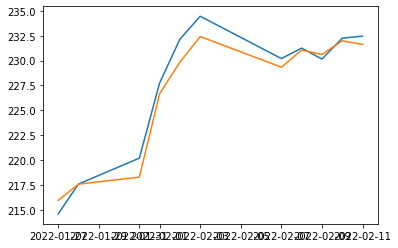

In [10]:
plt.plot(final_y_zeros.index[42:], (tf.squeeze(final_y_zeros[42:].to_numpy()).numpy())*k.values[0])
plt.plot(final_y_zeros.index[42:], preds)

In [11]:
model.save("GRU_itc")

INFO:tensorflow:Assets written to: GRU_itc\assets


INFO:tensorflow:Assets written to: GRU_itc\assets
